## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, plot
import plotly.express as px

import glob
import os

plt.rcParams["figure.figsize"] = 16,10


#imports from processing_funcs
from processing_funcs import *

## Create Features

### Read data

In [4]:
df = read_all()
df.head()

,time,lat,lon,height,velocity,direction,h_accuracy,v_accuracy,x_lin_acc,y_lin_acc,z_lin_acc,x_gyro,y_gyro,z_gyro,x_acc,y_acc,z_acc,label
time_groups,,,,,,,,,,,,,,,,,,
14,0.14,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,-0.068991,0.116175,-0.231500,-0.010804,0.001345,-0.033967,0.010029,-0.066162,9.487570,0
15,0.15,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,0.119553,0.105636,-0.053966,0.001346,0.008800,-0.035701,-0.054936,-0.025597,9.624087,0
16,0.16,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,0.013766,-0.061842,-0.085847,-0.007075,0.005302,-0.027966,0.181722,-0.081730,9.736653,0
17,0.17,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,0.063374,0.128633,-0.271607,-0.007945,0.006663,-0.028829,0.057930,-0.128134,9.693692,0
18,0.18,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,0.089934,0.096254,-0.355428,-0.004748,-0.002140,-0.035702,0.103884,-0.026944,9.488020,0


I decided to aggregate the data according to the gps data points. I think this is the most effective way to do so. It could be done with using other methodes, but all of the methods require data processing, which are increasing the computing capacity. 
It would be an option for example to using the speed of the car as the basis of the aggregation, but at the and we need to represent the data along the gps coordinates.

Let's see how many measurement points belongs to each gps data.

In [6]:
agg_df = df.groupby("lat").count()

It could be that the exact same gps coordinate exist not only one time. So we need to indentify each gps data points, to avoid the faulty data aggregation

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



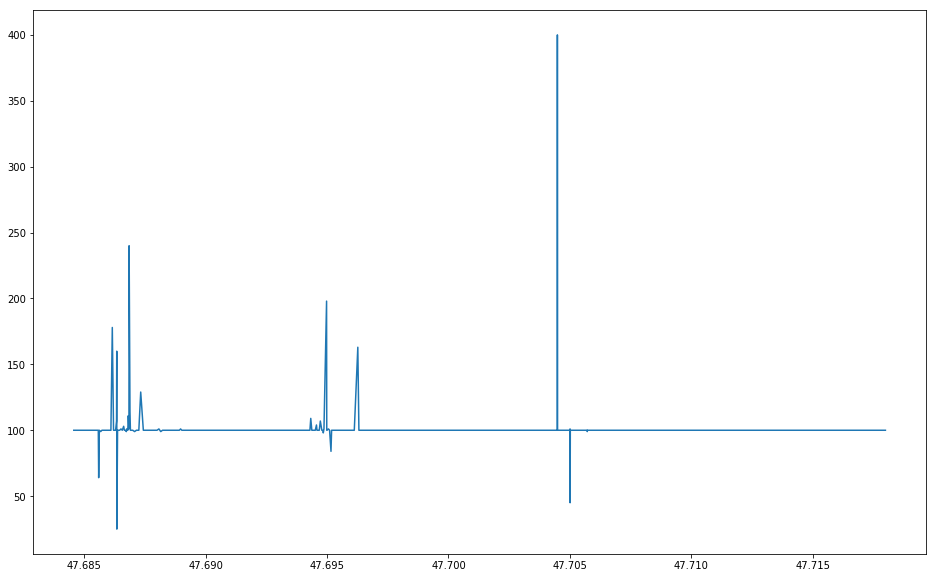

In [10]:
x = agg_df.index
y = agg_df.iloc[:,0].values
plt.plot(x,y)